In [8]:
using Random
using Plots

function generate_bars_and_stripes(n_samples, image_size)
    dataset = []
    labels = []

    for i in 1:n_samples
        # Randomly choose whether to generate a bar or a stripe
        is_bar = rand([true, false])

        # Generate the image
        if is_bar
            image = hcat(fill(1, image_size)...)
            label = 1  # 1 represents a bar
        else
            image = vcat(fill(1, image_size)...)
            label = 0  # 0 represents a stripe
        end

        push!(dataset, image)
        push!(labels, label)
    end

    return hcat(dataset...), labels
end

function plot_bars_and_stripes(data, labels, image_size)
    n_samples = length(labels)
    plot_grid = reshape(data, image_size, image_size, n_samples)

    plot_array = []
    for i in 1:n_samples
        push!(plot_array, heatmap(1:image_size, 1:image_size, plot_grid[:, :, i], c=:grays, color=:black, axis=false))
    end

    plot(plot_array..., layout=(1, n_samples), legend=false)
end

# Example usage
n_samples = 10
image_size = 5
data, labels = generate_bars_and_stripes(n_samples, image_size)
plot_bars_and_stripes(data, labels, image_size)

ArgumentError: ArgumentError: number of rows of each array must match (got (5, 5, 1, 5, 1, 1, 1, 5, 5, 5))

In [14]:
using Flux

function create_cnn()
    return Chain(
        Conv((3, 3), 1=>16, relu, bias = false), #Want to train 16 kernels, params = each entry in the kernel + the bias
        # MaxPool((2, 2)),
        # Conv((3, 3), 16=>32, relu),
        # MaxPool((2, 2)),
        # Flux.flatten,
        # Dense(50, 20, relu),
        # Dense(20, 10)
    )
end

function nparams(model)
    sum(length, Flux.params(model))
end

n = create_cnn()
Flux.params(n)
print(nparams(n))

144

In [4]:
using Yao
using FLOYao

nbatch = 10
yao_reg = zero_state(4; nbatch)
floyao_reg = FLOYao.zero_state(4; nbatch)

BatchedArrayReg{2, ComplexF64, Transpose...}
    active qubits: 4/4
    nlevel: 2
    nbatch: 10

In [2]:
function asdf(; a = 2, b = 3)
    a + b
end

result = asdf(b = 5)
println(result)  # This will correctly print 7

if 2<3 & 3<4
    print(5)
end

7
5

In [2]:
using Yao
using FLOYao
using Statistics

N = 2

g = chain(N)
push!(g, rot(kron(N, 1 => X, 2 => X), 0.)) #Rxx on two qubits
dispatch!(g, [0.3])

t = zero_state(N)
t |> g |> probs |> println

dispatch!(g, [0.3 + 2π])

t = zero_state(N)
t |> g |> probs |> println

[0.9776682445628029, 0.0, 0.0, 0.02233175543719699]
[0.9776682445628031, 0.0, 0.0, 0.02233175543719693]


In [41]:
using Yao
using FLOYao
using Statistics

N = 2

g = chain(N)
push!(g, rot(kron(N, 1 => X, 2 => X), 0.)) #Rxx on two qubits
dispatch!(g, rand(nparameters(g)).*2π)
theta = first(parameters(g))
println("true gradient: ", sin(theta)/2)

function loss(theta = theta)
    sin(theta/2)^2
end

ratio = 0
function pprior() #For each square, probability ratio that it's white, where ratio ~ N(mean(data), std(data)) /  N; maybe we can vary pprior later?
    a = rand(N) .< ratio
    return FLOYao.product_state(Int.(a)) #Returns MajoranaReg; Prepares it to be sent through the generator 
end

function postprocess(g_output::Vector) #turns the output of reg |> g |> measure into an Int vector
    result = []
    for i in 1:N 
        push!(result, g_output[1][end - i + 1])
    end
    Int.(result)
end

samplemean_batch = 5000
function run_g(nbatch = samplemean_batch)
    samples = []
    for i in 1:nbatch
        z = pprior() #MajoranaReg object
        result = z |> g |> measure |> postprocess
        if i == 1
            samples = result
        else
            samples = hcat(samples, result) #is this operation slow; on another note there has to be a better way to write this function right
        end
    end
    samples
end
#outputs an N * #samples matrix

function run_d_fake(samples)
    # if size(samples)[1] != N || typeof(samples) != Matrix{Int64} #Require samples to be an N x #samples matrix
    #     println("Improper formatting of samples")
    #     return
    # end
    # samples |> d
    mean(samples, dims = 1)
end

function gLoss(nbatch = samplemean_batch)
    #-mean(log.(run_d_fake(run_g(nbatch))))
    mean(run_d_fake(run_g(nbatch)))
end

eps = 1e-5
function finitediff_grad(g = g, eps = eps) #Computes forward finite differences
    original = gLoss()
    println("original loss: $original")
    a = loss(theta)
    println("original true loss: $a")
    temp_params = parameters(g)
    grad = zeros(nparameters(g))
    temp = 0
    for i in 1:nparameters(g)
        plus = 0
        temp = parameters(g)[i]
        temp_params[i] = temp + eps
        dispatch!(g, temp_params)
        plus = gLoss()
        println("plus: $plus")
        b = loss(theta + eps)
        println("plus true loss: $b")
        grad[i] = (plus - original) / eps #(L(θ+ε_i) - L(θ))/ε; L is computed by sample means
        println("true finitediff: ", (b-a) / eps)
        println(plus - original)
        println(b - a)
        temp_params[i] = temp
        dispatch!(g, temp_params)
    end
    grad
end

function parametershift_grad()
    temp_params = parameters(g)
    grad = zeros(nparameters(g))
    for i in 1:nparameters(g)
        plus = 0
        minus = 0
        temp = parameters(g)[i]
        temp_params[i] = temp + π/2
        dispatch!(g, temp_params)
        plus = gLoss()
        temp_params[i] = temp - π/2
        dispatch!(g, temp_params)
        minus = gLoss()
        grad[i] = (plus - minus) / 2
        temp_params[i] = temp
        dispatch!(g, temp_params)
    end
    grad
end

finitediff_grad() |> println
parametershift_grad() |> println


true gradient: 0.42957693580613227
original loss: 0.7596


original true loss: 0.7558586645462962
plus: 0.7586
plus true loss: 0.7558629603028613
true finitediff: 0.4295756565020347
-0.0010000000000000009
4.295756565020348e-6
[-100.00000000000009]


[0.4304]


In [ ]:
g = chain(N)
push!(g, rot(kron(N, 1 => X, 2 => X), 0.)) #Rxx on two qubits
dispatch!(g, rand(nparameters(g)).*2π)

batch = 100
function gLoss(nbatch = batch)
    
end

function parametershift_grad()
    temp_params = parameters(g)
    grad = zeros(nparameters(g))
    for i in 1:nparameters(g)
        plus = 0
        minus = 0
        temp = parameters(g)[i]
        temp_params[i] = temp + 0.5 #CHECK HOW SCALING WORKS FOR PARAMETERS
        dispatch!(g, temp_params)
        plus = gLoss()
        temp_params[i] = temp - 0.5
        dispatch!(g, temp_params)
        minus = gLoss()
        grad[i] = (minus - plus) / 2
        temp_params[i] = temp
        dispatch!(g, temp_params)
    end
    grad
end


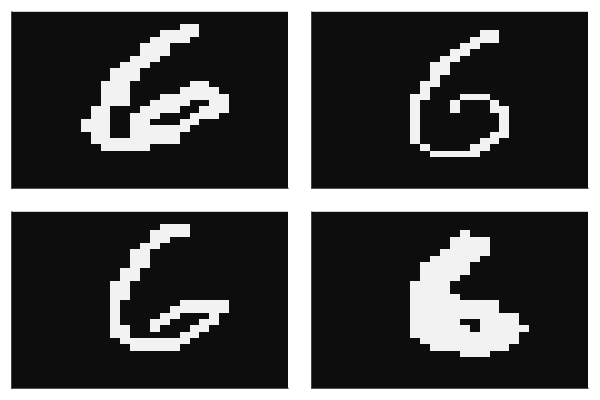

In [6]:
train = 4
digit = 6

train_set = MNIST(:train)
train_labels = MNIST(split=:train).targets

data_train = []
c = 1
for _ in 1:train
    while train_labels[c] != digit
        c += 1
    end
    push!(data_train, rotl90(train_set[c][1]) .> 0.5)
    c += 1
end

plot([heatmap(x, color=:grays, colorbar = false, ticks = false) for x in data_train]...) #Is there any way to make this look nicer? oh well it's not a big deal

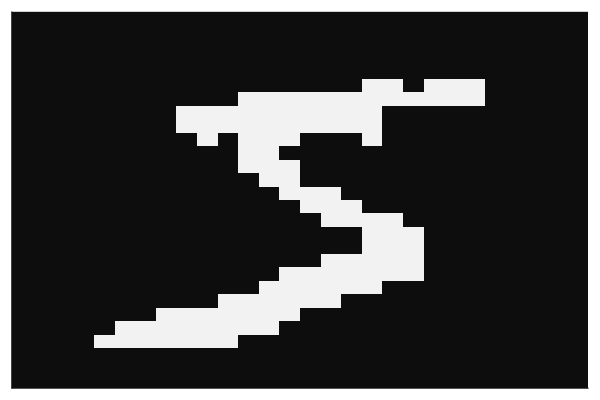

In [13]:
using MLDatasets
using Plots
using Pipe

train_set = MNIST(:train)

x = train_set[1][1] .> 0.5
#plot(heatmap(rotl90(x), color=:grays, colorbar = false, ticks = false))

@pipe x |> vec |> reshape(_,28,28) |> plot(heatmap(rotl90(_), color=:grays, colorbar = false, ticks = false))

In [11]:
using Yao

N = 25
layers = 5
g = chain(N) #Making the generator, which is a matchgate ansatz
for _ in 1:layers
    for i in 1:N-1
        push!(g, rot(kron(N, i => X, i+1 => X), 0.))
    end
    for i in 1:N
        push!(g, put(N, i => Rz(0.)))
    end
end

dispatch!(g, :random)
println(parameters(g))
println(gradient(g))

[0.5454626686557851, 0.7574492625513849, 0.8288533351588325, 0.8121839130737354, 0.12552915101072648, 0.9449062360449023, 0.5463687791664117, 0.09229772257843483, 0.5568924549066308, 0.5606486321948967, 0.010461406276843888, 0.9396887583769711, 0.5033459341696521, 0.1588589384576673, 0.20351001955108505, 0.023185381445060105, 0.020737005973914036, 0.7693453064289135, 0.4291949836119133, 0.038512856382333926, 0.4138697495045821, 0.3528613744291771, 0.0886504059715808, 0.7546837896669328, 0.9065112630180457, 0.014435950938044062, 0.31341134606466803, 0.8191564311438772, 0.014977154750417832, 0.19440099431543445, 0.022222811440033463, 0.2803969484485763, 0.1863378011903839, 0.9780947319509354, 0.9770000768581694, 0.9695813150441435, 0.22121343888594558, 0.5430396689439804, 0.8361670777653141, 0.4457170689144183, 0.29415865993639234, 0.6995218848765529, 0.773505573960813, 0.8338676902023647, 0.6136888339641369, 0.42417479772483313, 0.44765139314548197, 0.23702216203722126, 0.89792802578365

UndefVarError: UndefVarError: `gradient` not defined

In [21]:
using Yao
circuit = chain(4, repeat(4, H, 1:4), put(4, 3=>Rz(0.5)), control(2, 1=>X), put(4, 4=>Ry(0.2)))
circuit = circuit |> Yao.autodiff(:BP) #???????

UndefVarError: UndefVarError: `autodiff` not defined

In [7]:
using Flux

# Define a simple neural network
model = Chain(Dense(10, 5, relu), Dense(5, 2))

# Display the initial parameters
println("Initial Parameters:")
for p in params(model)
    println(p)
end
const initial = params
params = params(model)
println("initial: ", initial)

# Suppose you have new parameter values as vectors (of the correct dimensions)
new_params_layer1 = randn(5, 10)
new_params_layer2 = randn(5)
new_params_layer3 = randn(2, 5)
new_params_layer4 = randn(2)

# Set the new parameters
println("length ", length(params(model)))
params_layer1, params_layer2, params_layer3, params_layer4 = params(model)
println(size(params_layer1))
println(size(params_layer2))
println(size(params_layer3))
println(size(params_layer4))
params_layer1 .= new_params_layer1  # Use broadcasting assignment .=
params_layer2 .= new_params_layer2
params_layer3 .= new_params_layer3
params_layer4 .= new_params_layer4
println("initial: ", initial)

# Display the updated parameters
println("\nUpdated Parameters:")
for p in Flux.params(model)
    println(p)
end

new_params_layer1, new_params_layer2, new_params_layer3, new_params_layer4 = initial
println("asdf ", new_params_layer1)
params_layer1, params_layer2, params_layer3, params_layer4 = params(model)
params_layer1 .= new_params_layer1  # Use broadcasting assignment .=
params_layer2 .= new_params_layer2
params_layer3 .= new_params_layer3
params_layer4 .= new_params_layer4

println("\nInitial Parameters:")
for p in Flux.params(model)
    println(p)
end


Initial Parameters:
Float32[0.2586 0.2564478 -0.14705507 -0.6034778 -0.006969022 -0.55017704 -0.6041567 -0.5692597 0.5514455 0.40842122; 0.37690863 0.123033695 0.05006682 0.4423845 -0.63022286 0.43721518 -0.5289191 -0.38148215 0.47268787 -0.30389434; 0.18071061 0.6046077 0.25994346 0.4808553 -0.47517708 0.51701206 0.19030918 0.07959194 -0.48305234 0.037443433; 0.45869675 -0.21159495 -0.19798404 0.5784383 -0.0682152 -0.3134224 0.07947719 0.60297364 -0.3178038 0.28330582; 0.450709 -0.44164377 -0.38924357 0.023509612 -0.22734238 0.25996125 -0.3176807 -0.3897135 0.3003256 0.34115252]
Float32[0.0, 0.0, 0.0, 0.0, 0.0]
Float32[-0.46451345 -0.7161916 0.30781022 -0.5166258 -0.29030392; -0.772016 0.45951253 -0.09930434 0.38461727 -0.91004753]
Float32[0.0, 0.0]


ErrorException: cannot assign a value to imported variable Flux.params from module Main

In [23]:
using Flux
using LinearAlgebra
using Random

Random.seed!(2)

function n(a::Vector)
    return a[1]
end

model = Chain(
    Dense(4, 2, relu),
    Dense(2, 1),
    softmax
)

println(sum(length, Flux.params(model)))

data = [([1,2,3,4], 2), ([2,3,4,5], 3), ([3,4,5,6], 3)]
x = [1,2,3,4]
y = 2
loss3(m, x, y) = norm(m(x) .- y)     # the model is the first argument

opt_state = Flux.setup(Adam(), model)

initial = Flux.params(model)
println("asdf ", initial)
# for p in Flux.params(model)
#     p .= (ones(size(p)) .* 0.08)
# end

# epochs = 10
# for i in 1:epochs
#     Flux.train!(loss3, model, data, opt_state) 
#     s = 0
#     for d in data
#         s += loss3(model, d[1], d[2])
#     end
#     println("iteration $i: loss is $s")
# end

A = zeros(2,2)
setindex!(A, [10,20], [1,2])
A[[3, 4]] = [30, 40]
println(A)

println(Flux.params(model))

Flux.train!(loss3, model, data, opt_state)
#nparams = sum(length, Flux.params(model))

# for i in 1:nparams
#     #Flux.params(model)[i] = initial[i]
#     setindex!(Flux.params(model), initial[i],)
# end

println(Flux.params(model))

13
asdf Params([Float32[-0.82332647 -0.59481263 -0.40093803 0.38192046; -0.9954989 0.3614949 0.47065997 0.6134633], Float32[0.0, 0.0], Float32[0.017256774 -0.73138165], Float32[0.0]])
[10.0 30.0; 20.0 40.0]
Params([Float32[-0.82332647 -0.59481263 -0.40093803 0.38192046; -0.9954989 0.3614949 0.47065997 0.6134633], Float32[0.0, 0.0], Float32[0.017256774 -0.73138165], Float32[0.0]])
Params([

Float32[-0.82332647 -0.59481263 -0.40093803 0.38192046; -0.9954989 0.3614949 0.47065997 0.6134633], Float32[0.0, 0.0], Float32[0.017256774 -0.73138165], Float32[0.0]])


In [2]:
using Flux

# model = Chain(
#     Dense(4, 2, relu),
#     Dense(2, 1),
#     softmax
# )

# println(Flux.params(model))
# x = rand(Float32, 4)
# println(x)
# model(x)

model2 = Chain(
  Dense(10 => 5, σ),
  Dense(5 => 2),
  softmax)

x = rand(10)
y = rand(10)
model2(x) |> println
model2(y) |> println
hcat(x,y)
#model2(hcat(x,y))

Float32[0.5029387, 0.4970613]
Float32[0.52733314, 0.47266683]


10×2 Matrix{Float64}:
 0.0262499  0.979999
 0.332267   0.141428
 0.75646    0.554159
 0.154411   0.393257
 0.461534   0.627533
 0.818963   0.352821
 0.912385   0.921515
 0.948366   0.962068
 0.104596   0.253137
 0.736038   0.346649

In [ ]:
using Flux

N = 196

function NeuralNetwork(num_dim = N, random = true)
    net = Chain(Dense(num_dim, 25, relu), Dense(25, 1, x -> σ.(x)))
    if !random
        for p in Flux.params(net)
            p .= ones(size(p)) .* 0.08
        end
    end
    return x -> first(net(x))
end


d = NeuralNetwork()
d(ones(196))

In [ ]:
function dLoss(data::Vector) #the first half of data is D's output on real, the second half is D's output on fake
    len = length(data)÷2
    real = data[1:len]
    fake = data[len+1:end]
    (sum(log.(real)) + sum(log.(1 .- fake))) / len
end

print(dLoss([0.5,0.5,0.5,0.5]))

In [ ]:
using FLOYao

a = FLOYao.zero_state(4)

typeof(a)

In [ ]:
using Plots

# Sample data (matrices)
data_matrices = [rand(3, 3) for _ in 1:4]  # Create an array of 4 random 3x3 matrices

# Create an array of heatmap plots
heatmaps = [heatmap(data_matrix, title="Heatmap $i", color=:grays, c=:auto) for (i, data_matrix) in enumerate(data_matrices)]

# Combine the heatmaps into a single plot
plot(heatmaps..., layout=(2, 2))  # Arrange heatmaps in a 2x2 grid


In [ ]:
using Flux

# # Create a sample input tensor (4x4) with random values
# input_tensor = rand(4, 4)

# # Perform average pooling with a pooling size of 2x2 and a stride of 2
# pooled_tensor = Flux.MeanPool(input_tensor, (2, 2), (2, 2))

# println("Original tensor:")
# println(input_tensor)
# println("Pooled tensor:")
# println(pooled_tensor)


xs = rand(Float32, 100, 100, 3, 50);

m = Chain(Conv((5,5), 3 => 7), MeanPool((5,5), pad=SamePad()))
Chain(
  Conv((5, 5), 3 => 7),                 # 532 parameters
  MeanPool((5, 5), pad=2),
)

m[1](xs) |> size
#(96, 96, 7, 50)

m(xs) |> size
#(20, 20, 7, 50)

In [ ]:
using Flux

function NeuralNetwork()
    return Chain(
            Dense(2, 25,relu),
            Dense(25,1,x->σ.(x))
            )
end

m = NeuralNetwork()

#Flux.params(m)

print(m([1,2]))

In [ ]:
image_size = 5
N = image_size * image_size

ratio = 1/2
function pprior() #For each square, probability 1/ratio that it's white, where ratio ~ N(mean(data), std(data)); maybe we can vary pprior later?
    return rand(N) .< ratio
end

x = Int.(pprior())
x |> println

#heatmap(rotl90(reshape(x, image_size, image_size)) .> 0.5, color=:grays, colorbar = false, ticks = false)

using FLOYao
using Yao

state1 = FLOYao.product_state([0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0])
eeeee = FLOYao.product_state(x) 



In [ ]:
using Yao
using FLOYao

n = 4
t = FLOYao.rand_state(n)
print(typeof(t))

t |> probs |> println

v = state(t)
sum =  0
for x in v
    sum += abs2(x)
end
println(sum)

In [1]:
using Yao

N = 16
layers = 5
g = chain(N) #Making the generator, which is a matchgate ansatz
for _ in 1:layers
    for i in 1:N-1
        push!(g, rot(kron(N, i => X, i+1 => X), 0.))
    end
    for i in 1:N
        push!(g, put(N, i => Rz(0.)))
    end
end

dispatch!(g, :random)
arr = parameters(g)
println(parameters(g))
print(typeof(ones(155)))
dispatch!(+, g, ones(155))
println(parameters(g))
println(parameters(g) == (arr .+ 1))

[0.4186772651923395, 0.9443010326818442, 0.9604670690207017, 0.5014306245878104, 0.014814455133769333, 0.6637267892324535, 0.8004070214160125, 0.9933734646203043, 0.49515398288064283, 0.6727919478530155, 0.9453560786450677, 0.710193597552303, 0.07214187955821183, 0.8230923362961615, 0.08832122393214437, 0.40454056488880863, 0.7390263600292579, 0.5797557119669229, 0.30810036517773787, 0.6289055969175638, 0.5962374481127165, 0.6674566970526364, 0.3979664999995305, 0.2099511355743473, 0.4881279629787322, 0.721705513844638, 0.5959050022663406, 0.5104686890941542, 0.0906731497983767, 0.4016255460353315, 0.19651094999005136, 0.7133541848227378, 0.2259995313122779, 0.785819033906092, 0.35806641608012, 0.19741465119134816, 0.8937175847359243, 0.6891482434572337, 0.11512139314014469, 0.06888338178360953, 0.7300923035673231, 0.07082591622038015, 0.29573783538328047, 0.26422556923924934, 0.3990292986480022, 0.23689209314395354, 0.6309343564611205, 0.5260734735640302, 0.2257064801596993, 0.4843902

Vector{

Float64}

[1.4186772651923394, 1.9443010326818442, 1.9604670690207016, 1.5014306245878104, 1.0148144551337692, 1.6637267892324537, 1.8004070214160124, 1.9933734646203043, 1.4951539828806428, 1.6727919478530155, 1.9453560786450677, 1.710193597552303, 1.0721418795582118, 1.8230923362961615, 1.0883212239321445, 1.4045405648888085, 1.739026360029258, 1.5797557119669228, 1.3081003651777379, 1.6289055969175639, 1.5962374481127166, 1.6674566970526365, 1.3979664999995305, 1.2099511355743473, 1.4881279629787323, 1.721705513844638, 1.5959050022663406, 1.510468689094154, 1.0906731497983766, 1.4016255460353315, 1.1965109499900515, 1.7133541848227378, 1.225999531312278, 1.785819033906092, 1.3580664160801201, 1.1974146511913482, 1.8937175847359242, 1.6891482434572338, 1.1151213931401447, 1.0688833817836096, 1.7300923035673232, 1.0708259162203801, 1.2957378353832805, 1.2642255692392492, 1.3990292986480022, 1.2368920931439535, 1.6309343564611205, 1.5260734735640302, 1.2257064801596993, 1.484390236773382, 1.4550